[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

## GP 1D Data Generator

In [ ]:
#import os,sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
import numpy as np  
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

___

## VAE = Encoder + Decoder

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            eps = torch.randn_like(sd)
            return eps.mul(sd).add_(z_mu)
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [ ]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [ ]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [ ]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
len(train_ds)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [ ]:
import torch.optim as optim 

In [ ]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

## Training

In [ ]:
from tqdm import tqdm, trange

In [ ]:
t = trange(200)
for e in t:
    model.train()
    total_loss = 0
    for i, x in enumerate(train_dl):
        x = x[1].float().to(device)
        optimizer.zero_grad()
        x_pred, z_mu, z_sd = model(x)
        loss = compute_loss(x, x_pred, z_mu, z_sd)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()
    t.set_description(f'Loss is {total_loss/(samples*input_dim):.3}')

## Eval

In [ ]:
model.eval()
z = torch.randn(5, z_dim).to(device)

with torch.no_grad():
    x_sample = model.decoder(z)

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, y in enumerate(x_sample):
    ax.plot(train_ds.evalPoints[:,0], y.cpu().numpy(), marker='o', markersize=3)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('5 different function realizations at fixed 100 points\n'
    'sampled from a VAE learned with prior as GP (RBF)')
    #plt.savefig('plots/sample_prior_vae_1d_fixed.pdf')

## Inference

In [ ]:
observed = GP1D(input_dim, 1, ls=0.1)

In [ ]:
observed[0][1]

In [22]:
model = model.to('cpu')

In [23]:
decoder_dict = model.decoder.state_dict()

In [ ]:
decoder_dict

In [25]:
f = observed[0][1]

In [35]:
decoder_dict['linear1.bias'].T

tensor([ 0.0057,  0.0011, -0.0028, -0.0046,  0.0024,  0.0013,  0.0068, -0.0022,
         0.0011, -0.0030,  0.0030,  0.0009, -0.0056, -0.0017,  0.0142, -0.0018,
        -0.0015,  0.0020, -0.0022,  0.0009,  0.0054, -0.0103,  0.0107,  0.0002,
        -0.0017, -0.0025, -0.0048, -0.0015, -0.0025,  0.0064,  0.0013, -0.0005,
         0.0040,  0.0051, -0.0040,  0.0008,  0.0001,  0.0032,  0.0012, -0.0043,
         0.0024, -0.0023, -0.0138, -0.0043, -0.0023,  0.0013, -0.0039, -0.0042,
        -0.0091,  0.0041,  0.0103,  0.0020,  0.0013, -0.0044, -0.0091, -0.0005,
         0.0024, -0.0007,  0.0010, -0.0105,  0.0021,  0.0050,  0.0108,  0.0015])

In [26]:
y = f + np.random.randn(input_dim) * 0.1

In [29]:
stan_data = {
    "p": z_dim,
    "p1": hidden_dim1,
    "p2": hidden_dim2,
    'n': input_dim,
    "W1": decoder_dict['linear1.weight'].T.numpy(),
    'B1': decoder_dict['linear1.bias'].T.numpy(),
    'W2': decoder_dict['linear2.weight'].T.numpy(),
    "B2": decoder_dict['linear2.bias'].T.numpy(),
    "W3": decoder_dict['out.weight'].T.numpy(),
    "B3": decoder_dict['out.bias'].T.numpy(),
    'y': y
}

/tmp/ipykernel_282/1022859894.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  'B1': decoder_dict['linear1.bias'].T.numpy(),


## Stan

In [37]:
import cmdstanpy

In [44]:
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /home/dulunche/.cmdstan
CmdStan version 2.30.1 already installed


True

In [38]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_1D.stan')

14:09:05 - cmdstanpy - INFO - compiling stan file /home/dulunche/GP_VAE/drclab/stan_1D.stan to exe file /home/dulunche/GP_VAE/drclab/stan_1D
14:09:36 - cmdstanpy - INFO - compiled model executable: /home/dulunche/GP_VAE/drclab/stan_1D


In [40]:
fit = sm.sample(data= stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

14:11:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▋         | 00:00 Iteration:    1 / 2500 [  0%]  (Warmup)
chain 1 |██▉       | 00:00 Iteration:  501 / 2500 [ 20%]  (Sampling)


chain 1 |████▍     | 00:00 Iteration:  900 / 2500 [ 36%]  (Sampling)


chain 1 |█████▉    | 00:00 Iteration: 1300 / 2500 [ 52%]  (Sampling)


chain 1 |███████▍  | 00:00 Iteration: 1700 / 2500 [ 68%]  (Sampling)


chain 1 |████████▉ | 00:00 Iteration: 2100 / 2500 [ 84%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


14:11:04 - cmdstanpy - INFO - CmdStan done processing.


In [43]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,36.883400,0.060536,3.360630,30.780500,37.258400,41.74960,3081.90,1240.70,1.001050
z[1],-0.079838,0.008592,1.013600,-1.765160,-0.081457,1.56109,13917.50,5602.88,0.999774
z[2],-0.002819,0.008642,1.003710,-1.672500,-0.000586,1.65351,13488.10,5429.98,0.999703
z[3],2.020500,0.001248,0.138147,1.796040,2.019540,2.24973,12251.90,4932.34,0.999838
z[4],-0.049479,0.008065,1.013770,-1.722830,-0.061101,1.60017,15800.80,6361.05,0.999750
...,...,...,...,...,...,...,...,...,...
y2[96],2.014570,0.004164,0.385080,1.374570,2.015670,2.64515,8554.23,3443.73,1.000230
y2[97],1.852120,0.004350,0.382129,1.221390,1.851820,2.47573,7718.54,3107.30,0.999655
y2[98],1.662980,0.004103,0.383554,1.027920,1.666580,2.28724,8738.13,3517.77,0.999808
y2[99],1.473680,0.004221,0.380747,0.855929,1.469120,2.11060,8138.29,3276.29,1.000440


In [41]:
out = fit.stan_variables()

In [45]:
fit.diagnose()

'Processing csv files: /tmp/tmpjnv6os2m/stan_1Dvg6ejibc/stan_1D-20221028141103_1.csv, /tmp/tmpjnv6os2m/stan_1Dvg6ejibc/stan_1D-20221028141103_2.csv, /tmp/tmpjnv6os2m/stan_1Dvg6ejibc/stan_1D-20221028141103_3.csv, /tmp/tmpjnv6os2m/stan_1Dvg6ejibc/stan_1D-20221028141103_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [42]:
out

{'z': array([[-0.370926 ,  0.420656 ,  1.79311  , ..., -0.237559 , -1.21441  ,
          1.31409  ],
        [-0.160445 , -0.663087 ,  2.17071  , ...,  0.952725 , -0.0457183,
          1.25561  ],
        [-0.38339  , -1.98651  ,  1.9443   , ...,  2.51628  , -0.842295 ,
          1.57606  ],
        ...,
        [-0.0312365,  0.737711 ,  1.78517  , ...,  0.518468 ,  0.781256 ,
          1.18532  ],
        [-0.1344   , -0.531963 ,  2.10646  , ..., -0.70179  , -1.07339  ,
          1.43763  ],
        [ 0.956993 ,  0.4154   ,  2.03123  , ...,  1.14797  ,  0.769728 ,
          1.32128  ]]),
 'sigma2': array([0.350515, 0.346683, 0.353879, ..., 0.351548, 0.373817, 0.33316 ]),
 'f': array([[0.77017 , 0.88124 , 0.984726, ..., 1.38007 , 1.19762 , 1.0181  ],
        [0.754133, 0.871455, 0.984853, ..., 1.61775 , 1.43227 , 1.23787 ],
        [0.663774, 0.770081, 0.873273, ..., 1.68807 , 1.49228 , 1.28704 ],
        ...,
        [0.639157, 0.734724, 0.825491, ..., 1.538   , 1.35451 , 1.16456 ],
 

In [ ]:
fit.save

## Posterior Plotting

In [47]:
import arviz as az

array([[<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>]], dtype=object)

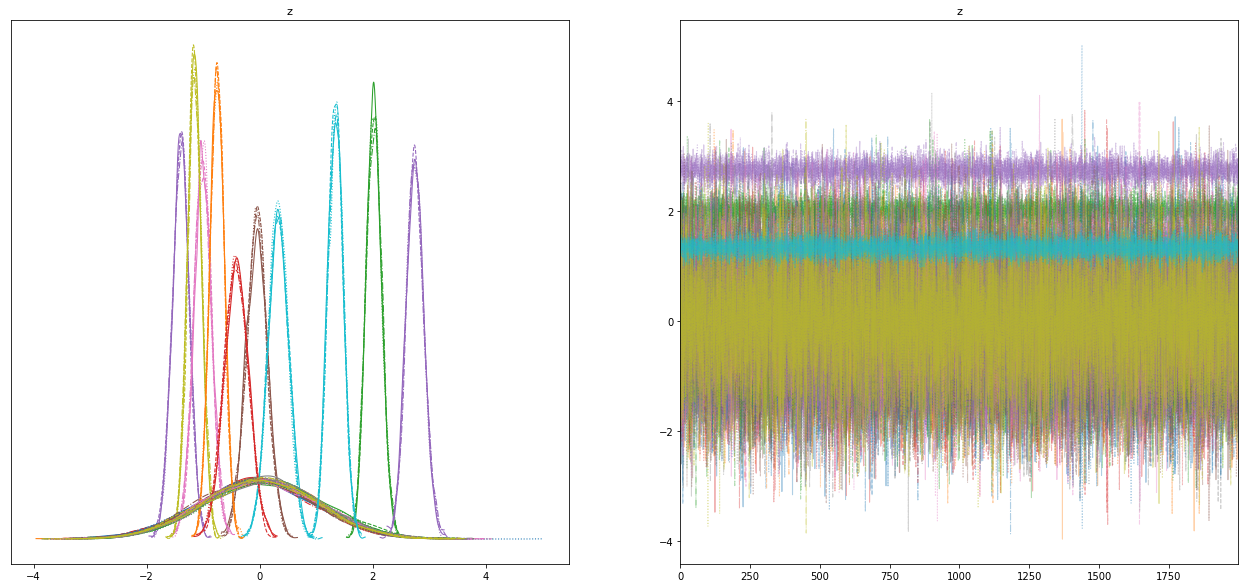

In [50]:
az.plot_trace(fit, var_names=["z"], figsize=(22,10))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

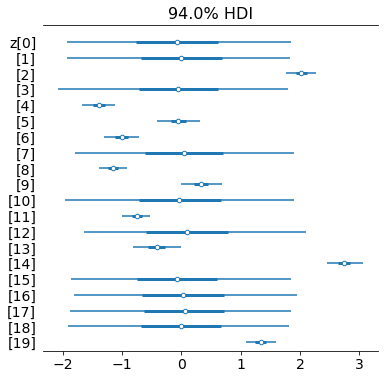

In [52]:
az.plot_forest(fit, var_names="z", combined=True)

In [57]:
import pandas as pd

In [58]:
datapoints = observed[0][0]
df = pd.DataFrame(out['y2'])

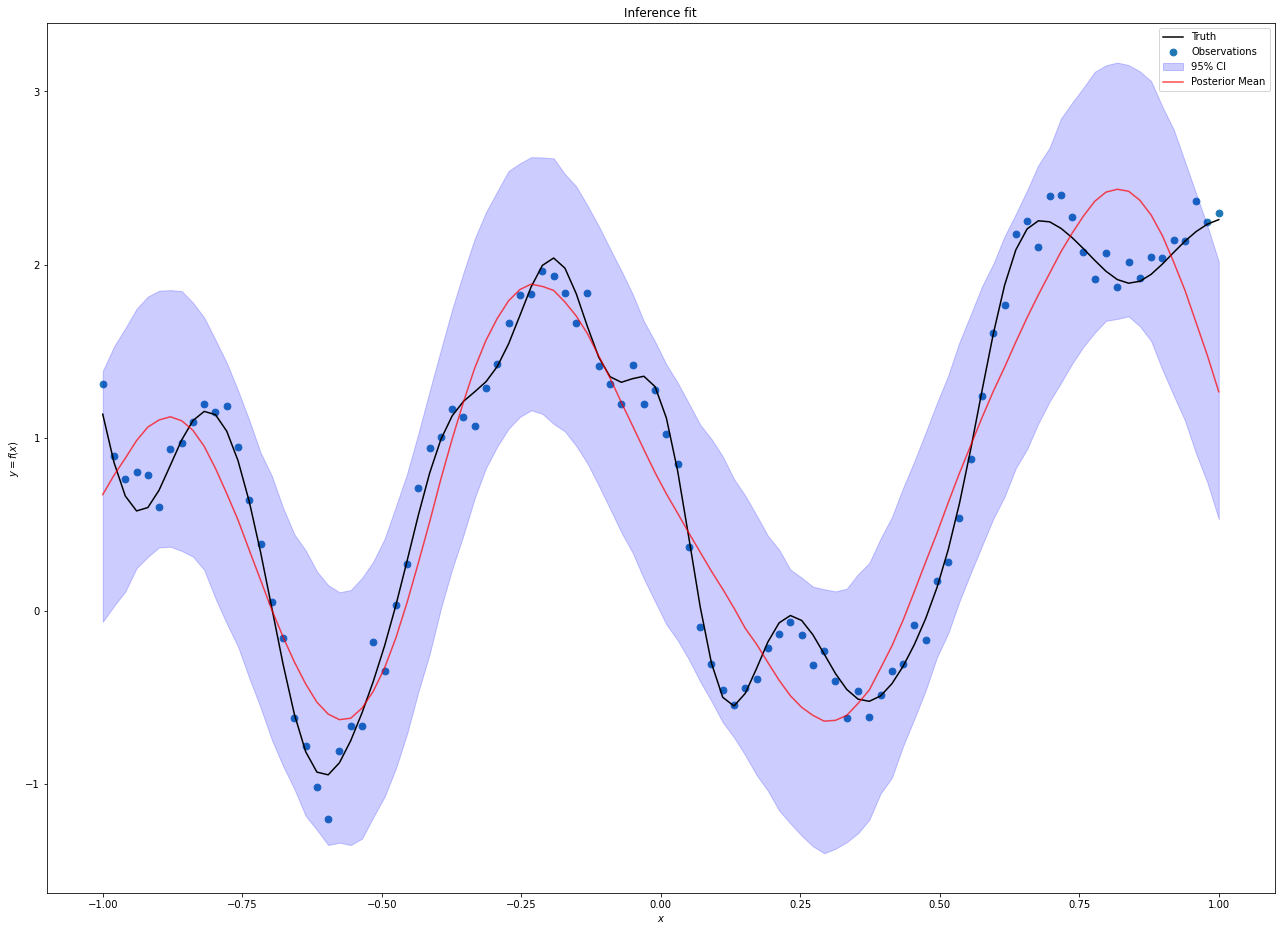

In [63]:
fig = plt.figure(figsize=(22,16))
ax = fig.add_subplot(111)
ax.plot(datapoints, f.reshape(-1,1), color="black", label="Truth")
ax.scatter(datapoints, y.reshape(-1,1), s=46, label="Observations")
ax.fill_between(datapoints, 
                df.quantile(0.025).to_numpy(), 
                df.quantile(0.975).to_numpy(),
                #facecolor = "blue",
                color="blue",
                alpha= 0.2,
                label = "95% CI"
)
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color="red", alpha=0.7,
    label="Posterior Mean"
)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()
